# Restaurant Recommendation System

## Notebook by [Wenyi Xu]("https://github.com/xuwenyihust")

### My own solution to Harvard CS 109 HW4
<br/>
### Import libraries & some preparation works

In [12]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.prop_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

### Load the dataset

In [13]:
fulldf=pd.read_csv("https://raw.githubusercontent.com/xuwenyihust/Restaurant-Recommendation-System/master/bigdf.csv")
fulldf.head(2)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


## Q1. Writing a simple "global" recommender

Assume that every users perceive the similarity between items in the same way. (**global similarity** instead of user-specific similarity)

Calculate the similarity between items by their entire common user support.

**common user support:** use the set of common raters of both items to measure the similarity between items.
<br/>
<br/>
### Exploratory Data Analysis

**1.1** Visualize the sparsity of the full data set by plotting two histograms of the review count grouped by the user_id and business_id respectively. Are there more users or more businesses?

We can see from the plots that users with 0~3 reviews are the most,

and that businesses with 0~5 reviews are the most.

<br/>

user_id
--65q1FpAL_UQtVZ2PTGew    108
--AqBuo717RyacADExYbSA      1
--LzFD0UDbYE-Oho3AhsOg      1
--M-cIkGnH1KhnLaCOmoPQ      1
--RD0Z_F0tV4L-AzhOzXYA      1
Name: review_id, dtype: int64


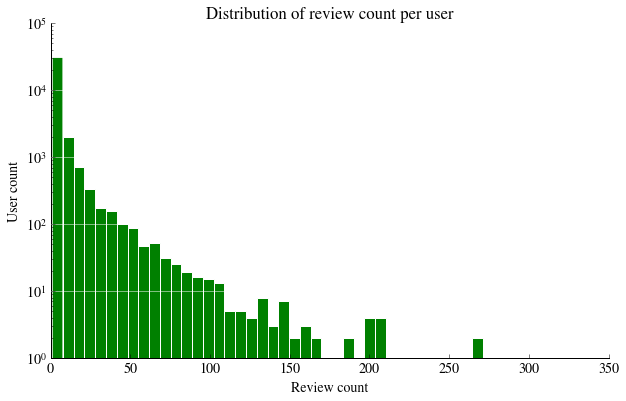

In [25]:
# Number of review_ids for each user_id
review_per_user = fulldf.groupby(["user_id"])["review_id"].count()
print(review_per_user[:5])

bin_cnt = len(set(review_per_user.tolist()))

fig, ax = plt.subplots()
ax.set(xlabel="Review count", ylabel="User count", title="Distribution of review count per user")
remove_border(ax)
#ax.axis('off')
plt.hist(review_per_user, bins=int(bin_cnt/3), log=True, color="Green")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()

business_id
--5jkZ3-nUPZxUvtcbr8Uw    11
--BlvDO_RG2yElKu9XA1_g    36
-0QBrNvhrPQCaeo7mTo0zQ     3
-0bUDim5OGuv8R0Qqq6J4A     6
-1bOb2izeJBZjHC7NWxiPA    47
Name: review_id, dtype: int64


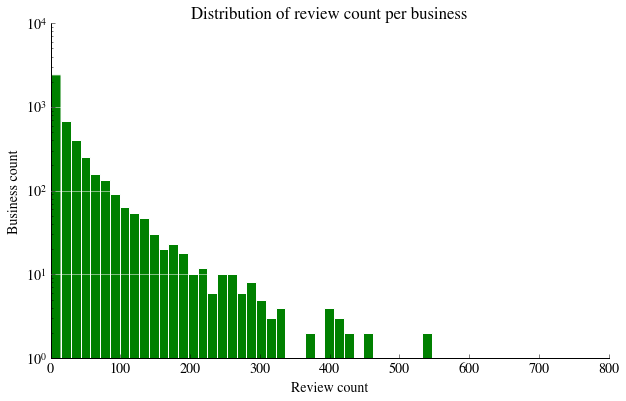

In [26]:
# Number of review_ids for each business_id
review_per_business = fulldf.groupby(["business_id"])["review_id"].count()
print(review_per_business[:5])

bin_cnt = len(set(review_per_business.tolist()))

fig, ax = plt.subplots()
ax.set(xlabel="Review count", ylabel="Business count", title="Distribution of review count per business")
remove_border(ax)
#ax.axis('off')
plt.hist(review_per_business, bins=int(bin_cnt/5), log=True, color="Green")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()

Compare the number of users & businesses.

In [16]:
user_cnt = len(set(fulldf["user_id"].tolist()))
business_cnt = len(set(fulldf["business_id"].tolist()))
print("More users than businesses.") if user_cnt > business_cnt else print("More users than businesses.")

More users than businesses.


<br/>

**1.2** Compute the average rating of reviews in the data set and a histogram of all the ratings in the dataset.

Average rating:  3.7414126802349332


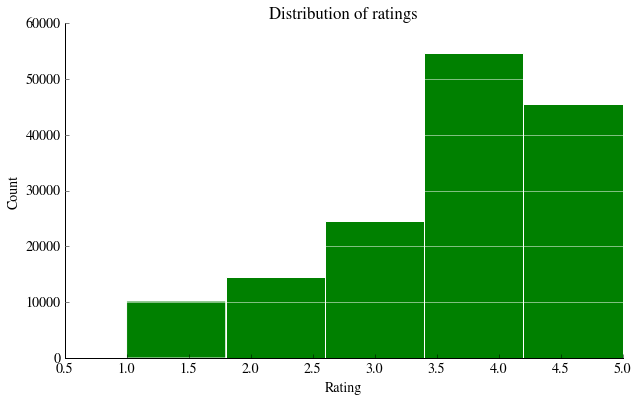

In [27]:
# The average rating of all reviews
avg_rating = fulldf["stars"].mean()
print("Average rating: ",avg_rating)

# Histogram of all the ratings
fig, ax = plt.subplots()
ax.set(xlabel="Rating", ylabel="Count", title="Distribution of ratings")
remove_border(ax)
plt.hist(fulldf["stars"], bins=5, color="Green")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()


<br/>
The following function is used to re-compute review counts and averages whenever you subset a reviews data frame. We'll use it soon to construct a smaller, more computationally tractable data frame.

<br/>

In [18]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf


<br/>
**1.3** Create a smaller data set in dataframe smalldf by looking for those businesses with more than 150 reviews and those users with more than 60 reviews. Include all the columns that were there in the parent dataframe. Since you have created a subset of the data set, use the method provided above to recalculate the averages. Print the number of unique users and items in this data set.

Note that while this cut makes sure we have prolific users, the cut on businesses restores sparsity by reducing the number of reviews per user.

<br/>

In [19]:
smalldf=fulldf[(fulldf.user_review_count > 60) & (fulldf.business_review_count > 150)]
smalldf=recompute_frame(smalldf)

How does this compare to the parent data set, in terms of size and sparsity? Once again, plot histograms of the review count grouped by user, and by the review count grouped by business, respectively, and describe the results

user_id
--65q1FpAL_UQtVZ2PTGew    32
-9mljS0O9mwdOnGv-Oea3Q     6
-F32Vl8Rk4dwsmk0f2wRIw    34
04xW5mhSBaCzpjbcf2VSZg    20
0bNXP9quoJEgyVZu9ipGgQ    65
Name: review_id, dtype: int64


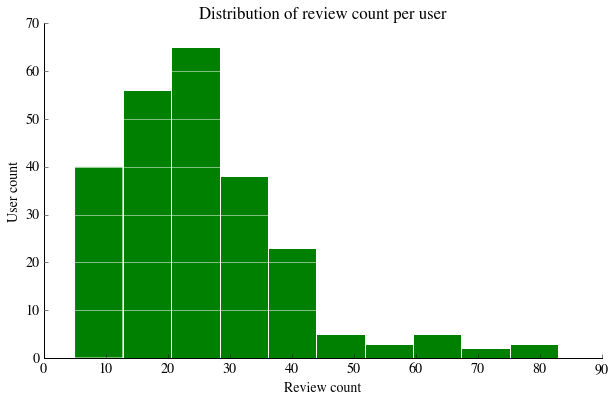

In [28]:
review_per_user = smalldf.groupby(["user_id"])["review_id"].count()
print(review_per_user[:5])

bin_cnt = len(set(review_per_user.tolist()))

fig, ax = plt.subplots()
ax.set(xlabel="Review count", ylabel="User count", title="Distribution of review count per user")
remove_border(ax)
#ax.axis('off')
plt.hist(review_per_user, bins=int(bin_cnt/5), log=False, color="Green")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()

business_id
-4A5xmN21zi_TXnUESauUQ    25
-AAig9FG0s8gYE4f8GfowQ    43
-bd26a1QEEpqUZjBmtBUiQ    26
-sC66z4SO3tR7nFCjfQwuQ    79
0K634ehk41ZRc4kj3NTAEQ    25
Name: review_id, dtype: int64


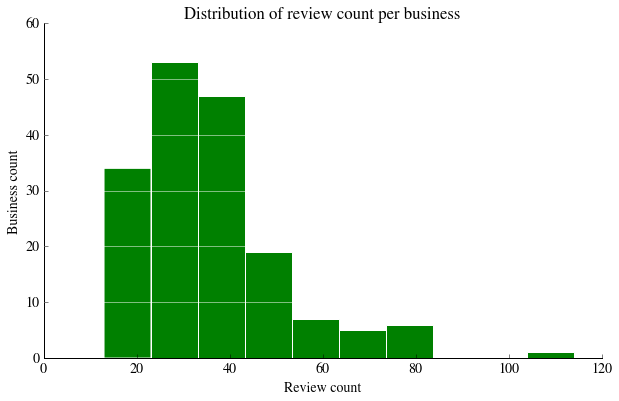

In [30]:
review_per_business = smalldf.groupby(["business_id"])["review_id"].count()
print(review_per_business[:5])

bin_cnt = len(set(review_per_business.tolist()))

fig, ax = plt.subplots()
ax.set(xlabel="Review count", ylabel="Business count", title="Distribution of review count per business")
remove_border(ax)
#ax.axis('off')
plt.hist(review_per_business, bins=int(bin_cnt/5), log=False, color="Green")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()

After the dataset filtering, the size of the new dataset is smaller, and the **sparsity is becoming less** too.

<br/>
**1.4** Compute histograms of the average user rating in the smaller data set, and the average business rating in the smaller data set. Print the overall mean.

<br/>

avg_ratings_by_user:  user_id
--65q1FpAL_UQtVZ2PTGew    4.218750
-9mljS0O9mwdOnGv-Oea3Q    2.333333
-F32Vl8Rk4dwsmk0f2wRIw    4.029412
04xW5mhSBaCzpjbcf2VSZg    3.400000
0bNXP9quoJEgyVZu9ipGgQ    3.246154
Name: stars, dtype: float64


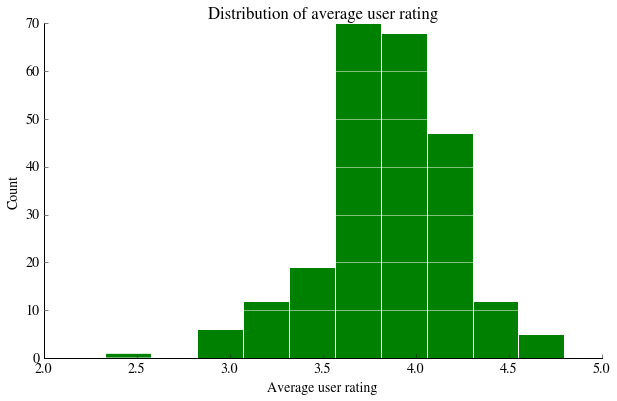

avg_ratings_by_business:  business_id
-4A5xmN21zi_TXnUESauUQ    4.120000
-AAig9FG0s8gYE4f8GfowQ    4.162791
-bd26a1QEEpqUZjBmtBUiQ    4.000000
-sC66z4SO3tR7nFCjfQwuQ    4.126582
0K634ehk41ZRc4kj3NTAEQ    3.680000
Name: stars, dtype: float64


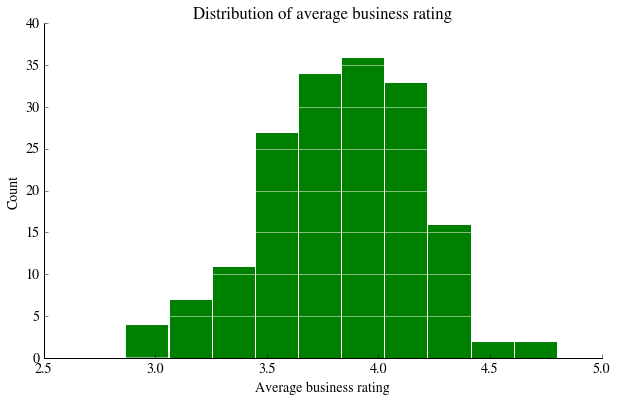

The overall mean:  3.867639902676399


In [37]:
# Average user rating
fig, ax = plt.subplots()
ax.set(xlabel="Average user rating", ylabel="Count", title="Distribution of average user rating")
remove_border(ax)

avg_ratings_by_user=smalldf.groupby('user_id').stars.mean()
print("avg_ratings_by_user: ", avg_ratings_by_user[:5])
plt.hist(avg_ratings_by_user, bins=int(bin_cnt/5), log=False, color="Green")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()

# Average business rating
fig, ax = plt.subplots()
ax.set(xlabel="Average business rating", ylabel="Count", title="Distribution of average business rating")
remove_border(ax)

avg_ratings_by_business=smalldf.groupby('business_id').stars.mean()
print("avg_ratings_by_business: ", avg_ratings_by_business[:5])
plt.hist(avg_ratings_by_business, bins=int(bin_cnt/5), log=False, color="Green")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()

# The overall mean:
print("The overall mean: ", smalldf["stars"].mean())


<br/>
### Common Support
Lets now make a histogram of the common user support (the number of common reviewers) of each pair of restaurants on the smaller set, and print the mean. Pay attention to the code, as you will use parts of it later. (This code takes a bit of time to run, so be patient).

The common support is an important concept, as for each pair of restaurants, its the number of people who reviewed both. It will be used to modify similarity between restaurants. If the common support is low, the similarity is less believable.

<br/>